# Activity curve

In this notebook I plot the swimming speed of bacteria as a function of time. 

In [225]:
import numpy as np
import pandas as pd
import os
import trackpy as tp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time

## A simple case

In [98]:
master_folder = '/home/zhengyang/data'
sf = next(os.walk(master_folder))[1]
pd.DataFrame().assign(sf=sf)

,sf
0,2021-05-18_16h55m12s-1-4
1,2021-05-18_16h20m59s-3-1
2,2021-05-18_17h34m08s-3-4
3,2021-05-18_16h04m54s-2-2
4,2021-05-18_16h06m22s-2-4
5,2021-05-18_17h34m40s-3-6
6,2021-05-18_17h35m27s-3-7
7,2021-05-18_17h34m21s-3-5
8,2021-05-18_16h54m35s-1-2
9,2021-05-18_16h06m50s-2-5


In [197]:
# read trajectory data
folder = os.path.join(master_folder, sf[11], 'Track')
traj = pd.read_csv(os.path.join(folder, 'Track.txt'), sep='\t', 
            header=None, usecols=[0, 1, 2, 3],
            names=['frame', 'x', 'y', 'z'])

<AxesSubplot:xlabel='frame'>

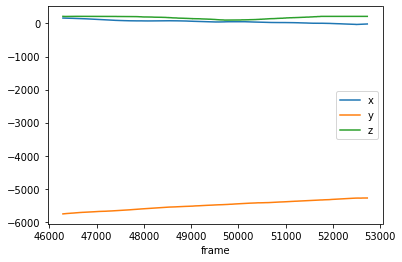

In [198]:
traj.set_index('frame').plot()

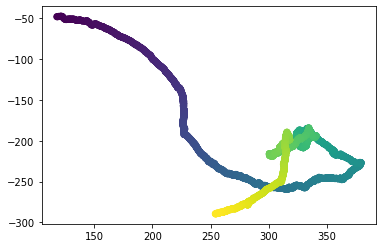

In [87]:
# plt.scatter(traj.x, traj.y, c=np.linspace(0, 1, len(traj)))

In [199]:
t1 = tp.link(traj, 100)

most_frequent = t1.particle.mode()[0]

t2 = t1.loc[t1.particle==most_frequent]

Frame 52729: 1 trajectories present.


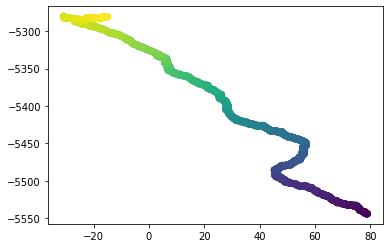

In [206]:
plt.scatter(t2.x, t2.y, c=np.linspace(0, 1, len(t2)))

In [207]:
msd = tp.emsd(t2, 1, 80, max_lagtime=80, pos_columns=['x', 'y', 'z'])

In [208]:
msd

lagt
0.0125     0.162612
0.0250     0.354866
0.0375     0.480536
0.0500     0.632080
0.0625     0.884189
            ...    
0.9500    55.924318
0.9625    57.322825
0.9750    58.735226
0.9875    60.165069
1.0000    61.609209
Name: msd, Length: 80, dtype: float64

Text(0, 0.5, 'MSD (um^2)')

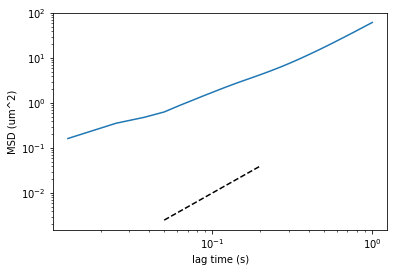

In [209]:
plt.plot(msd.index, msd)
plt.loglog()
x = np.array([5e-2, 2e-1])
y = x ** 2
plt.plot(x, y, ls='--', color='black')
plt.xlabel('lag time (s)')
plt.ylabel('MSD (um^2)')

In [220]:
def lin_1(x, b):
    return x + b

In [214]:
# dr^2 = (vt)^2, fit log(dr) = log(v) + log(t)

# truncate the msd to get a shorter time range for fitting
# turns out that 1 s is a pretty good range for observing a ballistic
# motion of swimming E. coli, so no truncating here
x = np.log(msd.index)
y = 0.5 * np.log(msd)
popt, pcov = curve_fit(lin_1, x, y)
v = np.exp(popt[0]) 
v # um/s

9.264725602019118

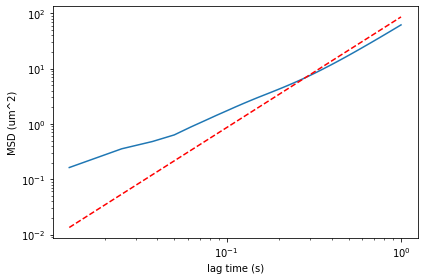

In [221]:
# save results
analysis_folder = os.path.join(master_folder, sf[11], 'analysis/MSD')
if os.path.exists(analysis_folder) == False:
    os.makedirs(analysis_folder)
with open(os.path.join(analysis_folder, 'velocity.txt'), 'w') as f:
    f.write('{:.2f}'.format(v))

# plot to see how the fitting works
plt.plot(msd.index, msd)
plt.loglog()
plt.plot(msd.index, np.exp(2*lin_1(np.log(msd.index), *popt)),
         color='red', ls='--')
plt.xlabel('lag time (s)')
plt.ylabel('MSD (um^2)')
plt.tight_layout()
plt.savefig(os.path.join(analysis_folder, 'msd.jpg'))

## Validate method

The method above uses MSD to calculate single particle velocity. The velocity value obtained is ~2 um/s, which contradicts my experience. I therefore try to validate the method here, by simulating a trajectory with known parameters (in particular velocity) and use MSD to calculate the velocity. 

In [177]:
v = 2 # a constant velocity
t = np.arange(100) 
x0 = 0
y0 = 0
theta0 = 0
x = []
y = []
theta = []
np.random.seed(0)
for i in t:
    dtheta = 1 * (np.random.rand() - 0.5)
    theta1 = theta0 + dtheta
    x1 = x0 + v * np.cos(theta1)
    y1 = y0 + v * np.sin(theta1)
    theta.append(theta1)
    x.append(x1)
    y.append(y1)
    theta0 = theta1
    x0 = x1
    y0 = y1

Text(0.5, 1.0, 'simulated trajectory')

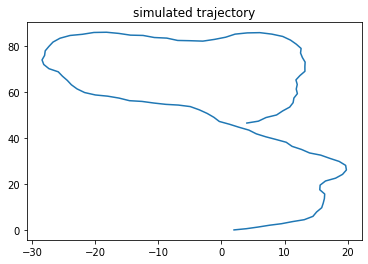

In [175]:
plt.plot(x, y)
plt.title('simulated trajectory')

In [178]:
# construct dataframe traj
traj = pd.DataFrame().assign(frame=t, x=x, y=y, particle=0)

In [182]:
# measure velocity
msd = tp.emsd(traj, 1, 1)
msd_t = msd.iloc[:2]
x_fit = np.log(msd_t.index)
y_fit = 0.5 * np.log(msd_t)
popt, pcov = curve_fit(lin_1, x_fit, y_fit)
v = np.exp(popt[0])
v # um/s

1.989418419126558

The method is valid. The velocity is set at 2 and the measurement returns 1.99, within 0.5% precision.

The core issue is the MPP setting. The input traj is not in the unit of pixel, but rather in microns. Simply change the MPP in MSD calculation to 1 (from 0.1) and reasonable velocity (~20 um/s) is obtained.

## Batch analysis

Calculate MSD and velocity for all the Track.txt data in data folder. Check the folder 'MSD' before performing the calculation. If exists, skip.

Frame 661183: 1 trajectories present.


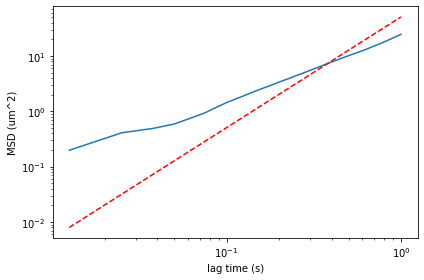

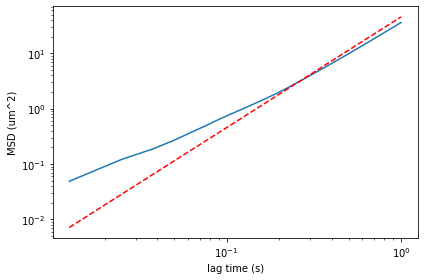

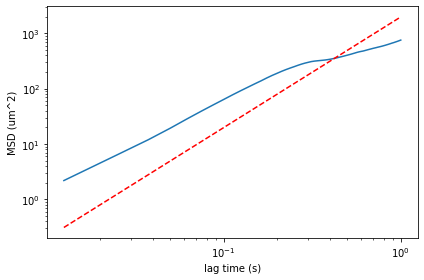

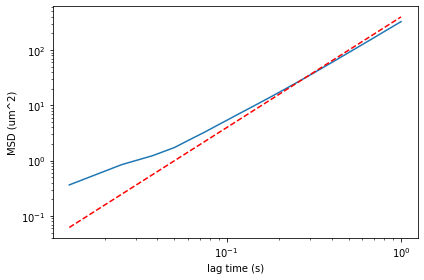

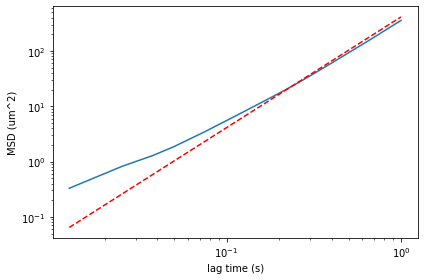

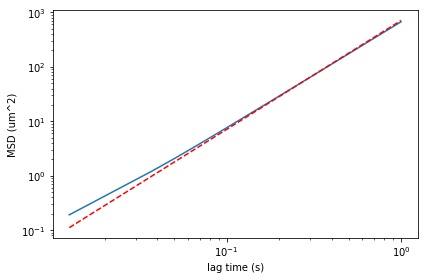

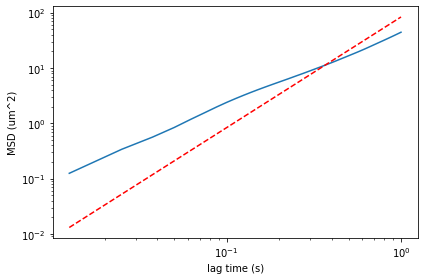

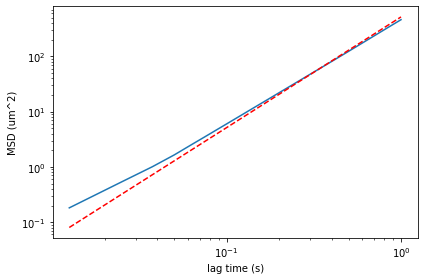

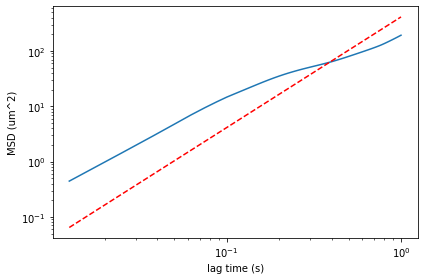

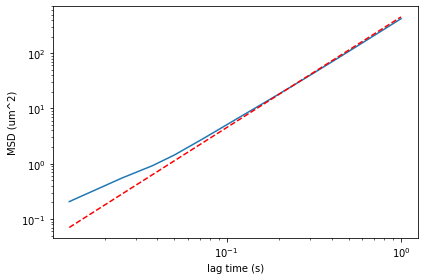

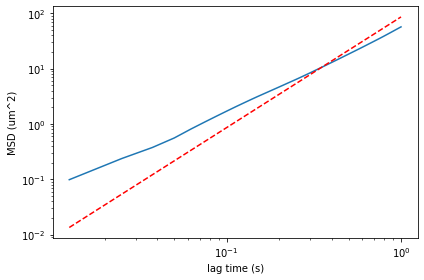

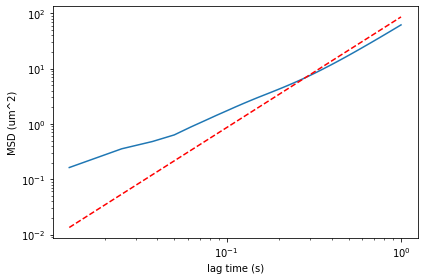

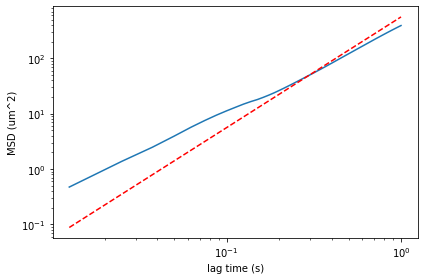

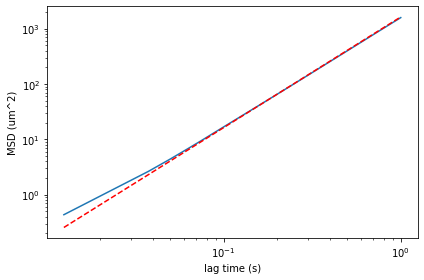

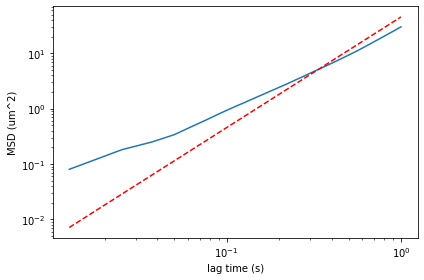

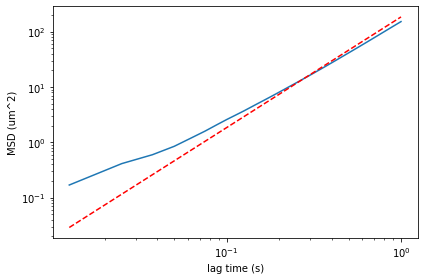

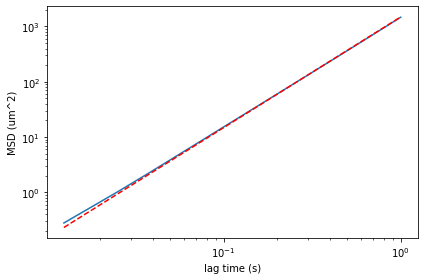

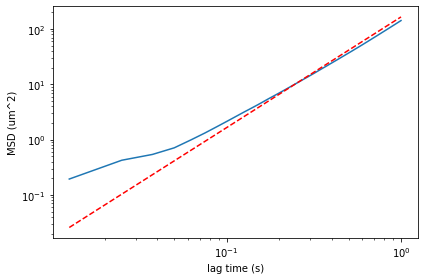

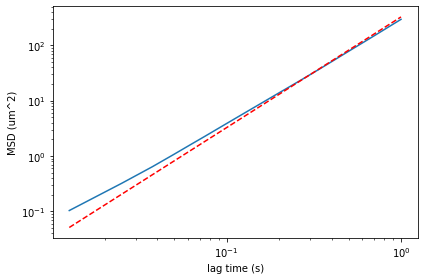

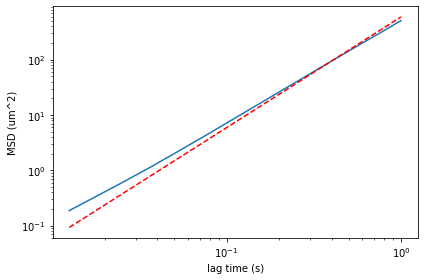

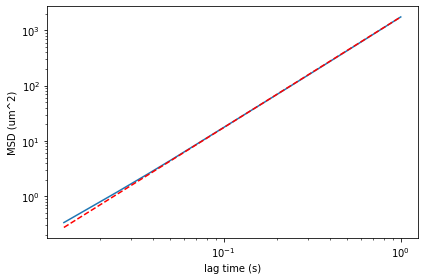

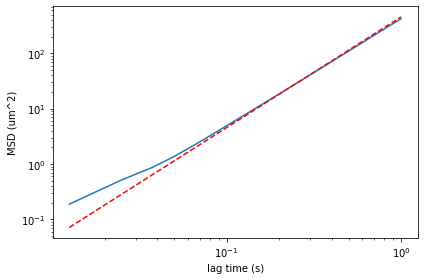

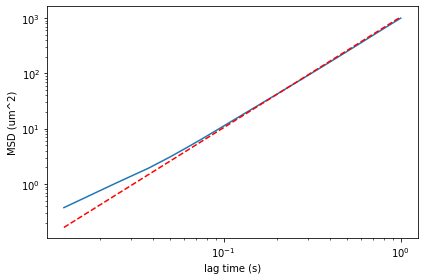

In [229]:
master_folder = '/home/zhengyang/data'
sf = next(os.walk(master_folder))[1]
log_file = os.path.join(master_folder, 'log.txt')
if os.path.exists(log_file) == False:
    with open(log_file, 'w') as f:
        pass
data_folder_list = []
velocity_list = []
for s in sf:
    track_folder = os.path.join(master_folder, s, 'Track')
    analysis_folder = os.path.join(master_folder, s, 'analysis')
    if os.path.exists(track_folder) == True: # and \
       #os.path.exists(analysis_folder) == False:
        data_folder_list.append(s)
        traj = pd.read_csv(os.path.join(track_folder, 'Track.txt'), sep='\t', 
                    header=None, usecols=[0, 1, 2, 3],
                    names=['frame', 'x', 'y', 'z'])
        t1 = tp.link(traj, 100)
        most_frequent = t1.particle.mode()[0]
        t2 = t1.loc[t1.particle==most_frequent]
        assert(len(t2) >= 100) # only process trajectories > 100
        msd = tp.emsd(t2, 1, 80, max_lagtime=80, pos_columns=['x', 'y', 'z'])
        x = np.log(msd.index)
        y = 0.5 * np.log(msd)
        popt, pcov = curve_fit(lin_1, x, y)
        v = np.exp(popt[0])
        velocity_list.append(v)
        
        msd_folder = os.path.join(analysis_folder, 'MSD')
        if os.path.exists(msd_folder) == False:
            os.makedirs(msd_folder)
        with open(os.path.join(msd_folder, 'velocity.txt'), 'w') as f:
            f.write('{:.2f}'.format(v))

        # plot to see how the fitting works
        fig, ax = plt.subplots()
        ax.plot(msd.index, msd)
        ax.loglog()
        ax.plot(msd.index, np.exp(2*lin_1(np.log(msd.index), *popt)),
                 color='red', ls='--')
        ax.set_xlabel('lag time (s)')
        ax.set_ylabel('MSD (um^2)')
        plt.tight_layout()
        fig.savefig(os.path.join(msd_folder, 'msd.jpg'))        
        with open(log_file, 'a') as f:
            f.write(time.asctime() + r' \\ ' + s + ' processed\n')
    else:
        with open(log_file, 'a') as f:
            f.write(time.asctime() + r' \\ ' + s + ' not processed\n')

In [232]:
# write velocity data
velocity_data = pd.DataFrame().assign(item=data_folder_list, 
                                     velocity=velocity_list)
velocity_data.to_csv(os.path.join(master_folder, 'velocity_data.csv'), index=False)

## 5-18 data analysis

### 1. Effect of Percoll

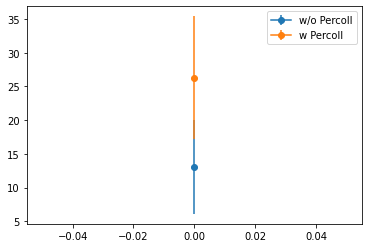

In [241]:
wo = np.array([7.14, 6.75, 26.67, 9.14, 22.68, 20.30, 9.27, 9.26, 6.76, 12.85])
w = np.array([19.91, 20.29, 21.26, 23.69, 40.43, 13.61, 38.58, 18.11, 24.39, 41.75, 21.39, 32.38])
plt.errorbar(0, wo.mean(), yerr=wo.std(), marker='o', label='w/o Percoll')
plt.errorbar(0, w.mean(), yerr=w.std(), marker='o', label='w Percoll')
plt.legend()

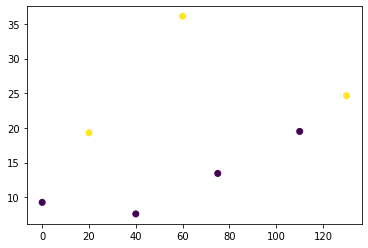

In [251]:
t = np.array([0, 20, 40, 60, 75, 110, 130])
v_groups = [[9.26],
             [21.39, 19.91, 13.61, 20.29, 21.26],
             [6.75, 6.76, 9.27],
             [41.75, 38.58, 40.43, 23.69],
             [20.3, 12.85, 7.14],
             [22.68, 26.67, 9.14],
             [23.69, 32.38, 18.11, 24.39]]
v_mean = []
v_std = []
for v in v_groups:
    v_mean.append(np.array(v).mean())
    v_std.append(np.array(v).std())
c = np.array([0, 1, 0, 1, 0, 0, 1])

plt.scatter(t, v_mean, c=c)

In [249]:
v_groups.shape

(7,)